# Porto Seguro EDA 금메달 커널 리뷰 (한글커널)

![Main Image](https://www.cqcs.com.br/wp-content/uploads/2020/01/Design-sem-nome-1.jpg)

### 대회 정보
 - Porto Seguro는 브라질의 자동차 보험 회사라고 한다. 
 - 이 대회의 목적은 어떤 차주가 내년에 보험 청구를 할 확률을 예측하는 것
 - predict_proba라는 함수를 사용해서 값을 예측 (확률 값)
 - 대회의 평가지표는 특이하게 Normalized Gini Coefficient를 사용함 
 - Normalized Gini Coefficient를 사용하는 이유: <br>
   Imbalanced Class를 평가를 위한 임계값을 어떻게 정하느냐에 따라 예측값이 바뀜 <br>
    = ROC 커브로 확인 (면적으로 스코어를 매김) >> 비슷한 목적으로 Gini Coefficient가 쓰임 <br>
    = gini = 2 * AUC - 1 <br>
    출처: https://stats.stackexchange.com/questions/306287/why-use-normalized-gini-score-instead-of-auc-as-evaluation
 
 
### 데이터 정보  (*데이터를 파악하는 것이 기본, 중요하기 때문에 대회에 나간다면 꼭 확인할 것*) 
 - 59만 개의 train set과 89만 개의 test set으로 구성되어 있음 
 - 실제 기업 데이터이기 때문에 feature를 비식별화 해놨음 (그렇기 때문에 난이도가 높은 쪽에 속함)
 - feature들이 그루핑 되어 있음 (비식별화 해놨으니 어떤거에 관련된거다 라고 주어진듯)<br>
   ind: 정수값 매핑 <br>
   reg: region(..?) <br>
   car: 차에 관련된 변수 <br>
   calc: 실수값 (계산된 값..?) <br>
 - bin은 binary feature, cat은 categorical feature에 해당 
 - 나머지는 그냥 연속형 변수 or 순서형 변수
 - 모든 Null Value는 -1로 대체되어 있음
 - 타겟값은 이전에 보험 청구가 있었으면 1 아니면 0으로 되어있음

### 참고한 상위 커널

1. https://www.kaggle.com/bertcarremans/data-preparation-exploration

# Data Check

In [1]:
# import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.impute import SimpleImputer # 결측치 대체를 위한 라이브러리
from sklearn.preprocessing import PolynomialFeatures # 교호작용 변수 생성 (중요한 변수끼리의 곱)
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold # FeatureSelection에서 분산이 기준치보다 낮은 feature는 탈락
from sklearn.feature_selection import SelectFromModel # Feature Importance를 제공하는 모델의 importance를 활용하여 변수선택

from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)

In [2]:
# porto 대회가 워낙 옛날 대회이다보니 그 사이에 캐글 인터페이스나 데이터 경로들이 변경되었음
# 모든 대회들이 하위 폴더가 하나 혹은 몇개씩 더 생겼으므로 path를 지정해주는 것이 편함

data_path = "../input/porto-seguro-safe-driver-prediction/"

df_train = pd.read_csv(data_path+"train.csv")
df_test = pd.read_csv(data_path+"test.csv")

In [3]:
df_train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [4]:
df_test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7,1,-1,0,-1,1,1,1,2,1,65,1,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4,1,-1,0,0,11,1,1,0,1,103,1,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11,1,-1,0,-1,14,1,1,2,1,29,3,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.1,0.2,-1.000000,7,1,-1,0,-1,1,1,1,2,1,40,2,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.4,0.817771,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1


In [5]:
# 데이터의 행과 열을 확인해본다.
# 타겟과 id를 제외한 58개의 feature가 존재한다.
# 특이한 점은 train set이 test set보다 적다.

print(df_train.shape)
print(df_test.shape)

(595212, 59)
(892816, 58)


In [6]:
df_train.isnull().sum()

id                0
target            0
ps_ind_01         0
ps_ind_02_cat     0
ps_ind_03         0
ps_ind_04_cat     0
ps_ind_05_cat     0
ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_14         0
ps_ind_15         0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0
ps_reg_01         0
ps_reg_02         0
ps_reg_03         0
ps_car_01_cat     0
ps_car_02_cat     0
ps_car_03_cat     0
ps_car_04_cat     0
ps_car_05_cat     0
ps_car_06_cat     0
ps_car_07_cat     0
ps_car_08_cat     0
ps_car_09_cat     0
ps_car_10_cat     0
ps_car_11_cat     0
ps_car_11         0
ps_car_12         0
ps_car_13         0
ps_car_14         0
ps_car_15         0
ps_calc_01        0
ps_calc_02        0
ps_calc_03        0
ps_calc_04        0
ps_calc_05        0
ps_calc_06        0
ps_calc_07        0
ps_calc_08        0
ps_calc_09        0
ps_calc_10        0
ps_calc_11        0


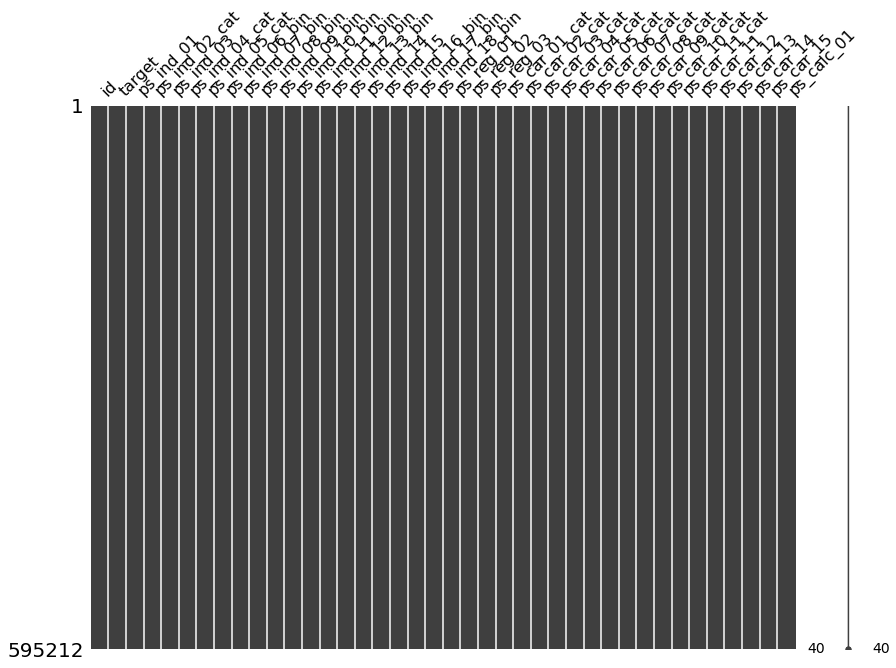

In [7]:
import missingno as msno # 결측치 시각화 라이브러리

msno.matrix(df=df_train.iloc[:,:40], figsize=(14, 10))

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

### 데이터 형태의 종류를 간단하게 살펴본다.

- Binary 변수
- 정수로 이루어진 Categorical 변수 (집값예측과 비슷, 범주형이지만 일단 인코딩이 필요해보이진 않는다.)
- 나머지 변수는 int와 float로 이루어져 있음
- Null값은 -1로 이루어져 있으므로 isnull()로 확인되지 않음

## Metadata

### 금메달 상위 커널인 'Data Prepraration&Exploration'은 아래와 같은 방법으로 데이터를 정리해두었다.

### FE, Visualization에서 편하게 데이터를 사용할 수 있는 꿀팁인듯

- 데이터의 역할: input, ID, target
- 데이터의 레벨: nominal, interval, ordinal, binary
- 버릴지 안버릴지: True or False (아래의 경우는 id 변수만 버리고 나머지는 가져감)
- 데이터의 타입: int, float, str

In [9]:
# append를 위해 빈 리스트를 만들어주었음
data = []

for f in df_train.columns:
    # 데이터의 역할을 지정 (독립변수, 종속변수, id (PM))
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
         
    # 데이터의 레벨을 지정 (명목변수, 간격변수, 순서변수등을 레벨이라고 표현한 듯)
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif df_train[f].dtype == float:
        level = 'interval'
    elif df_train[f].dtype == int:
        level = 'ordinal'
        
    # id는 False로 지정해주어 버리기로 하고, 나머지는 True로 가져감
    keep = True
    if f == 'id':
        keep = False
    
    # 데이터의 타입 지정
    dtype = df_train[f].dtype
    
    # DataFrame으로 만들기 위해 리스트에 append하기 전에 딕셔너리 타입으로 만들어주었음
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)

# 변수의 이름을 인덱스로 하는 데이터프레임을 만들어줌     
meta = pd.DataFrame(data, columns = ["varname", "role", "level", "keep", "dtype"])
meta.set_index("varname", inplace = True)

In [10]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


### 위의 방법대로 만들어서 어떤식으로 활용할 수 있는가?

ex1. 버리지 않을 변수중에서 nominal(명목형 변수)만 확인해보고 싶다. <br>
ex2. 각 레벨의 역할과 레벨에 해당하는 변수가 몇개가 있는지 확인해보고 싶다. <br>

In [11]:
# ex1

meta[(meta["level"] == "nominal") & (meta["keep"])].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [12]:
# ex2

meta.groupby(["role", "level"])["role"].size()

role    level   
id      nominal      1
input   binary      17
        interval    10
        nominal     14
        ordinal     16
target  binary       1
Name: role, dtype: int64

### 위에서 만들어준 정리를 통해 유형별로 데이터를 어떻게 다룰 것인가를 쉽게 선택할 수 있음

### ex. 연속형 변수의 경우 통계적 방법, 범주형 변수의 경우 시각화를 통한 탐색 등

### 블로그에 있는 집값예측 베이스라인을 보면 알 수 있듯이 위의 방법이 좀 복잡하게 느껴진다면, 그냥 연속형 변수/범주형 변수로만 나누어도 충분히 편하게 작업을 수행할 수 있음 

# EDA

## Interval 변수

In [13]:
Interval = meta[(meta["level"] == "interval") & (meta["keep"])].index

In [14]:
# describe를 통해 interval 변수들의 통계량을 확인 

df_train[Interval].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


### 위의 통계량을 바탕으로 Interval 데이터를 살펴보자

1) 결측치 확인
 - 말했듯이 Porto 대회의 결측치는 전부 -1로 대체되어 있다. <br>
 - 그렇기 때문에 isnull()이 아닌 -1값을 확인해주면 된다. <br>
 - 위의 통계량을 보면 min값이 -1인 변수가 몇개 존재한다. <br>
 - ps_reg_03, ps_car_12, ps_car_14 (calc 변수는 결측치 X)
            
2) 변수들 사이의 범위 확인
 - 범위를 확인해보면 변수들 간의 차이가 있지만 커보이지는 않는다. <br>
 - Scaling을 할지 말지 추후에 생각해보도록한다. (아마 트리모델을 사용할것이기 때문에 딱히..)

3) 변수들의 숫자 크기 확인
 - 어떤 변수인지 확인할 수는 없지만 변수의 크기가 전부 작은것으로 보인다. <br>
 - 이 커널을 작성한 사람은 Log를 씌워준게 아닌가 라고 생각했다.

## Ordinal 변수

In [15]:
Ordinal = meta[(meta["level"] == "ordinal") & (meta["keep"])].index

In [16]:
# describe를 통해 Ordinal 변수들의 통계량을 확인 

df_train[Ordinal].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


### 위의 통계량을 바탕으로 Ordinal 데이터를 살펴보자

1) 결측치 확인
 - 위의 통계량을 보면 min값이 -1인 변수가 한개 존재한다. <br>
 - ps_car_11 (나머지는 결측치 X)
            
2) 변수들 사이의 범위 확인
 - Ordinal 데이터 또한 범위를 확인해보면 변수들 간의 차이가 있지만 커보이지는 않는다. <br>

## Binary 변수

In [17]:
Binary = meta[(meta["level"] == 'binary') & (meta["keep"])].index

In [18]:
# describe를 통해 Ordinal 변수들의 통계량을 확인 

df_train[Binary].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 위의 통계량을 바탕으로 Binary 데이터를 살펴보자

1) 결측치 확인
 - 결측치 X
            
2) 변수들 사이의 범위 확인
 - Binary 데이터이기 때문에 범위를 확인할 필요는 없다. (0 or 1)
 
3) Target 변수 확인 
 - Binary에는 Target 변수까지 포함되어 있다.<br>
 - 그렇기 때문에 Target 변수에 대한 통계량을 확실하게 짚고 가야한다 <br>
 - Target 데이터의 평균을 살펴보면 이 대회의 핵심을 알 수 있다.
 - 데이터는 0 or 1 이기 때문에 균형이 맞기 위해선 평균이 0.5가 되어야 한다.
 - 하지만 Target 데이터의 평균은 0.0364로 보인다. (굉장히 Imbalanced하다. 0이 훨씬 많아보인다)
 - 대회의 Metric으로 Normalized Gini Coefficient를 사용하는 이유

### Imbalanced Class 처리

- 보험이라는 도메인 특성상 불균형적인 타겟값은 사실 일반적이다.
- 보험을 청구하는 경우 (1) 보다 하지 않는 경우 (0)이 굉장히 많은 것을 위에서 확인하였다.
- Imbalanced한 데이터는 일반적으로 Undersampling 혹은 Oversampling으로 처리한다.
- UnderSampling: 0이 1보다 훨씬 많으므로 0인 데이터를 줄여 균형을 맞춰준다.
- OverSampling: 0이 1보다 훨씬 많으므로 1인 데이터를 늘려 균형을 맞춰준다.
- 선택방법: 본인의 결정이지만 보통 데이터셋의 크기를 기준으로 선택한다. <br>
  데이터가 너무 많으면, 오버샘플링 시 너무 많은 Cost가 들어가게 된다(시간, 컴퓨팅파워) <br>
  이 커널은 데이터가 많은편이라고 판단하여 언더샘플링을 수행하였다.
  
**커널을 떠나서 불균형 방법을 해소하는 방법은 완벽가이드 책에 나왔던 SMOTE란 방법이 있다. (오버샘플링에 해당)** <br>
참고: https://datascienceschool.net/view-notebook/c1a8dad913f74811ae8eef5d3bedc0c3/ <br>
**추가로 Class_weights라는 방법도 존재한다. (불균형 class의 가중치를 조정)** <br>
참고: https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html <br>
**성능을 확인하고 어떤 방법으로 불균형을 해소할지 판단하면 된다.** 

Text(0.5, 1.0, 'Target PiePlot')

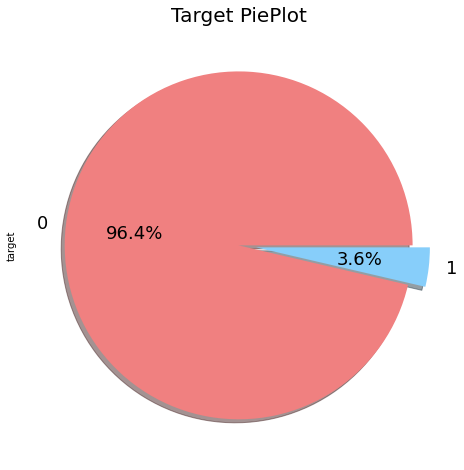

In [19]:
f, ax = plt.subplots(figsize = (8,8))

df_train['target'].value_counts().plot.pie(explode = [0, 0.1], autopct = '%1.1f%%', 
                                               shadow = True, colors = ['lightcoral', 'lightskyblue'],
                                              textprops={'fontsize': 18})
plt.title("Target PiePlot", size = 20)

# 불균형이 굉장히 심하다.

In [20]:
# 언더샘플링 비율을 지정해주기 위함 
desired_apriori=0.10

# target 변수의 클래스에 따른 인덱스 지정 
idx_0 = df_train[df_train["target"] == 0].index
idx_1 = df_train[df_train["target"] == 1].index

# 지정해준 인덱스로 클래스의 길이(레코드 수) 지정
nb_0 = len(df_train.loc[idx_0])
nb_1 = len(df_train.loc[idx_1])

# 언더샘플링 수행
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('target=0에 대한 언더샘플링 비율: {}'.format(undersampling_rate))
print('언더샘플링 전 target=0 레코드의 개수: {}'.format(nb_0))
print('언더샘플링 후 target=0 레코드의 개수: {}'.format(undersampled_nb_0))

# 언더샘플링 비율이 적용된 개수 만큼 랜덤하게 샘플을 뽑아서 그 인덱스를 저장
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# 언더샘플링 인덱스와 클래스 1의 인덱스를 리스트로 저장
idx_list = list(undersampled_idx) + list(idx_1)

# 저장한 인덱스로 train set 인덱싱
df_train = df_train.loc[idx_list].reset_index(drop=True)

target=0에 대한 언더샘플링 비율: 0.34043569687437886
언더샘플링 전 target=0 레코드의 개수: 573518
언더샘플링 후 target=0 레코드의 개수: 195246


### 위의 방법이 너무 복잡하다면 이미 있는 라이브러리를 사용할 수도 있다.

In [21]:
# 실습을 위해 불균형 데이터 랜덤으로 생성 

import scipy as sp

n0 = 200; n1 = 20
rv1 = sp.stats.multivariate_normal([-1, 0], [[1, 0], [0, 1]])
rv2 = sp.stats.multivariate_normal([+1, 0], [[1, 0], [0, 1]])
X0 = rv1.rvs(n0, random_state=0)
X1 = rv2.rvs(n1, random_state=0)
X_imb = np.vstack([X0, X1])
y_imb = np.hstack([np.zeros(n0), np.ones(n1)])
X_train = pd.DataFrame(data = X_imb, columns = ["X0", "X1"])
y_train = pd.DataFrame(data = y_imb, columns = ["target"])

#-------------------------------------------------------------------------------------------------------------
# 1) RandomUnderSampler

from imblearn.under_sampling import RandomUnderSampler
Undersampled_train, Undersampled_target = RandomUnderSampler(random_state=0).fit_sample(X_train, y_train)

nb_0 = len(y_train[y_train["target"] == 0.0].index)
undersampled_nb_0 = len(Undersampled_target[Undersampled_target["target"] == 0.0].index)

print('RandomUnderSampler 전 target=0 레코드의 개수: {}'.format(nb_0))
print('RandomUnderSampler 후 target=0 레코드의 개수: {}'.format(undersampled_nb_0))

#-------------------------------------------------------------------------------------------------------------
# 2) TomekLinks

from imblearn.under_sampling import TomekLinks
Undersampled_train, Undersampled_target = TomekLinks().fit_sample(X_train, y_train)

RandomUnderSampler 전 target=0 레코드의 개수: 200
RandomUnderSampler 후 target=0 레코드의 개수: 20


### 결측치 확인  

- 위에서 간단하게 어느 feature에 결측치가 있는지 확인하였다.
- 얼마나 있는지도 확인해보자.

In [22]:
vars_with_missing = []

# 모든 컬럼에 -1이라는 값이 1개 이상 있는 것을 확인하여 출력
# 어느 변수에 몇개의 레코드가 있는지, 비율은 얼마나 되는지 까지 확인하여 깔끔하게 출력된다.

for f in df_train.columns:
    missings = df_train[df_train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/df_train.shape[0]
        
        print('Variable {}\t has {:>10} records\t ({:.2%})\t with missing values'.format(f, missings, missings_perc))
print()        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat	 has        103 records	 (0.05%)	 with missing values
Variable ps_ind_04_cat	 has         51 records	 (0.02%)	 with missing values
Variable ps_ind_05_cat	 has       2256 records	 (1.04%)	 with missing values
Variable ps_reg_03	 has      38580 records	 (17.78%)	 with missing values
Variable ps_car_01_cat	 has         62 records	 (0.03%)	 with missing values
Variable ps_car_02_cat	 has          2 records	 (0.00%)	 with missing values
Variable ps_car_03_cat	 has     148367 records	 (68.39%)	 with missing values
Variable ps_car_05_cat	 has      96026 records	 (44.26%)	 with missing values
Variable ps_car_07_cat	 has       4431 records	 (2.04%)	 with missing values
Variable ps_car_09_cat	 has        230 records	 (0.11%)	 with missing values
Variable ps_car_11	 has          1 records	 (0.00%)	 with missing values
Variable ps_car_14	 has      15726 records	 (7.25%)	 with missing values

In total, there are 12 variables with missing values


### 중요한것은 Null Value를 처리할 때 항상 Null값의 의미를 파악해야한다.
> 진짜 결측된 값인지 <br> 
> 결측된 값 때문에 target에 변화를 줄 수 있는지 <br>
> 0으로 표현되었을 경우 Null Value인지 혹은 진짜 0으로 관측된 값인지 <br>
> 이 대회처럼 -1로 표현되었을 경우 실제 -1인 값을 가질수도 있는지 <br>
> 등등 <br>


### 커널의 경우 어떤 기준인지는 나와있지 않고 어떻게 처리했는지만 나온다.
- ps_car_03_cat와 ps_car_05_cat는 결측치가 굉장히 많은 것으로 보인다. 
- 이러한 변수는 확실한 대체방법이 있지 않는 이상 제거하는것이 좋다.
- 이 커널은 ps_car_03_cat와 ps_car_05_cat를 제외한 나머지 cat 변수들은 -1값을 그대로 두었다.
- ps_reg_03의 경우 평균으로 대체해준다. 
- ps_car_11의 경우 결측치가 딱 한개 있다. 최빈값으로 대체해준다. (순서형 변수이므로)
- 결론적으로 이 커널에서는 연속형 변수는 mean, 범주형 변수는 mode로 채워준다.

In [23]:
# 결측치가 너무 많았던 변수들 제거 
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
df_train.drop(vars_to_drop, inplace=True, axis=1)

# 만들어주었던 메타데이터 업데이트 (버린 변수를 keep = True에서 False로)
meta.loc[(vars_to_drop),'keep'] = False  

# 그 외의 결측치를 평균과 최빈값으로 대체
# SimpleImputer를 사용 (커널에서는 그냥 Imputer를 사용하는데 업데이트 후 이름이 바뀐듯)
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
df_train['ps_reg_03'] = mean_imp.fit_transform(df_train[['ps_reg_03']])
df_train['ps_car_12'] = mean_imp.fit_transform(df_train[['ps_car_12']])
df_train['ps_car_14'] = mean_imp.fit_transform(df_train[['ps_car_14']])
df_train['ps_car_11'] = mode_imp.fit_transform(df_train[['ps_car_11']])

### 범주형 변수의 유니크값 확인

 - 이 대회는 범주형 변수가 전부 숫자로 매핑되어있다.
 - 범주형 변수의 유니크 값과 몇개의 유니크 값이 있는지 확인해본다.

In [24]:
# 이 커널에서는 이런식으로 유니크값이 몇개있는지 확인했다.

Nominal = meta[(meta["level"] == 'nominal') & (meta["keep"])].index

for f in Nominal:
    dist_values = df_train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


In [25]:
# 개인적인 생각으로는 이 코드와 같이 nuniuqe()를 사용하면 훨씬 간편하지 않을까 싶다.

Nominal = meta[(meta["level"] == 'nominal') & (meta["keep"])].index

for f in Nominal:
    print('Variable {} has {} distinct values'.format(f, df_train[f].nunique()))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


### 범주형 변수 인코딩

- 범주형 변수를 인코딩하는 방법에서 일반적으로 one-hot-encoding, Label-encoding 방법을 사용한다. 
- 두 가지 방법이 어떻게 이루어지는지는 다들 알거라 생각하고 생략한다.
- one-hot-encoding은 변수에 순서(높고 낮음)이 부여되지 않기 때문에 target을 예측하는데 영향을 주진 않지만 unique값이 많을 경우 굉장히 sparse한 벡터가 생성되고, 또한 faeture도 기하급수적으로 늘어나기 때문에 cost가 늘어나고 차원의 저주에 빠질 확률이 높아진다. 
- Label-encoding의 경우 feature가 유지되기 때문에 cost가 적고 차원을 신경쓸 필요가 없지만 각각 unique 값에 매핑되는 숫자에 순서가 생겨버리기 때문에 target 예측에 영향을 줄 수 있다.
- 이 커널에서는 mean-encoding이라는 방법을 사용했다.


### mean-encoding
- 어떻게 이루어지는에 대한 설명은 아래 예시와 같다.
- 캐글에서는 mean encoding, frequency encoding 등 방법들을 많이 사용한다고 한다.
- 차원의 저주에 빠질 확률이 없고 빠르다는 장점이 있다.
- 가장 큰 장점으로는 target과의 mean을 취해주었기 때문에 일종의 상관관계를 가지게 된다.
- 하지만 치명적인 단점이 있다. 
- 바로 Data Leakage 문제와 오버피팅 문제이다.
- test 및 추후 수집될 데이터 셋에 대한 target 값을 알지 못하기 때문에 target에 대한 평균을 train 데이터 셋으로만 적용시켜야 한다.
- 그렇기 때문에 test 셋의 target 값을 사용하게 되면 data leakage 문제에 빠지게되고, train 셋의 target 값만 사용하게 되면 오버피팅되는 딜레마가 있다.
- 특히 train, test 셋의 unique값 분포가 크게 다를 때 오버피팅 문제는 커지게 된다.
- ex. train 셋의 남자 95명 여자5명, test 셋의 남자 50명, 여자 50명

### 단점을 어떻게 극복하는가?
- 이러한 단점들을 완화시키기 위한 방법들이 여러가지 있다. <br>
1) smoothing <br>
2) CV <br>
3) Expanding mean <br>
출처: https://dailyheumsi.tistory.com/120

### mean-encoding 예시

In [26]:
# 아래와 같은 데이터가 있다고 가정해보자

ex_list = [("남자", 1), ("여자", 1), ("여자", 1), ("여자", 0), ("남자", 0)]

ex = pd.DataFrame(data = ex_list, columns = ["성별", "target"])

In [27]:
# 이런 방법으로 인코딩을 수행한다.
# 인코딩할 범주형 변수와 target을 groupby해준 후 평균값을 취해준다.

성별_mean = ex.groupby("성별")["target"].mean()

In [28]:
# 그렇게 되면 아래와 같은 값을 얻을 수 있다.
# 남자의 경우 2개의 데이터에서 target값이 1과0 이므로 0.5가 나오고,
# 여자의 경우 3개의 데이터에서 target값이 1이 2개 0이 1개이므로 0.6667이 나온다.
# 이 값으로 해당 unique값을 인코딩 해준다.

성별_mean

성별
남자    0.500000
여자    0.666667
Name: target, dtype: float64

In [29]:
# 커널에서 구현한 mean-encoding 코드
# 코드가 매우 복잡해보이지만 결국 위에서 보았던 예제 방식을 구현한 것이다.
# 오버피팅 방지를 위해 noise를 추가하고, smoothing을 적용하기 때문에 코드가 복잡해보인다.
# smoothing을 통해 평균값이 치우친 상황을 조금이나마 보완해준다. (전체 평균값으로 가깝게)
# smoothing에 대한 자세한 이론은 위의 설명에 있는 출처 링크에서 확인! 


# 오버피팅 방지를 위해 약간의 noise를 추가한다고 한다.
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # agg를 사용해서 평균값을 구해줌
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # 오버피팅 방지를 위한 smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    prior = target.mean()
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # train, test에 적용시켜준다.
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
  
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [30]:
# 위에서 구현한 함수를 ps_car_11_cat(104개의 유니크 값)에 적용시켜준다.
# feature가 바뀌었으므로 메타데이터를 업데이트 해준다.

train_encoded, test_encoded = target_encode(df_train["ps_car_11_cat"], 
                             df_test["ps_car_11_cat"], 
                             target=df_train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
df_train['ps_car_11_cat_te'] = train_encoded
df_train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep'] = False  
df_test['ps_car_11_cat_te'] = test_encoded
df_test.drop('ps_car_11_cat', axis=1, inplace=True)

## 시각화를 통한 데이터 탐색

### 범주형 변수 시각화 
target이 1인 범주형 변수들의 특성을 시각화를 통해 파악해본다.

<Figure size 432x288 with 0 Axes>

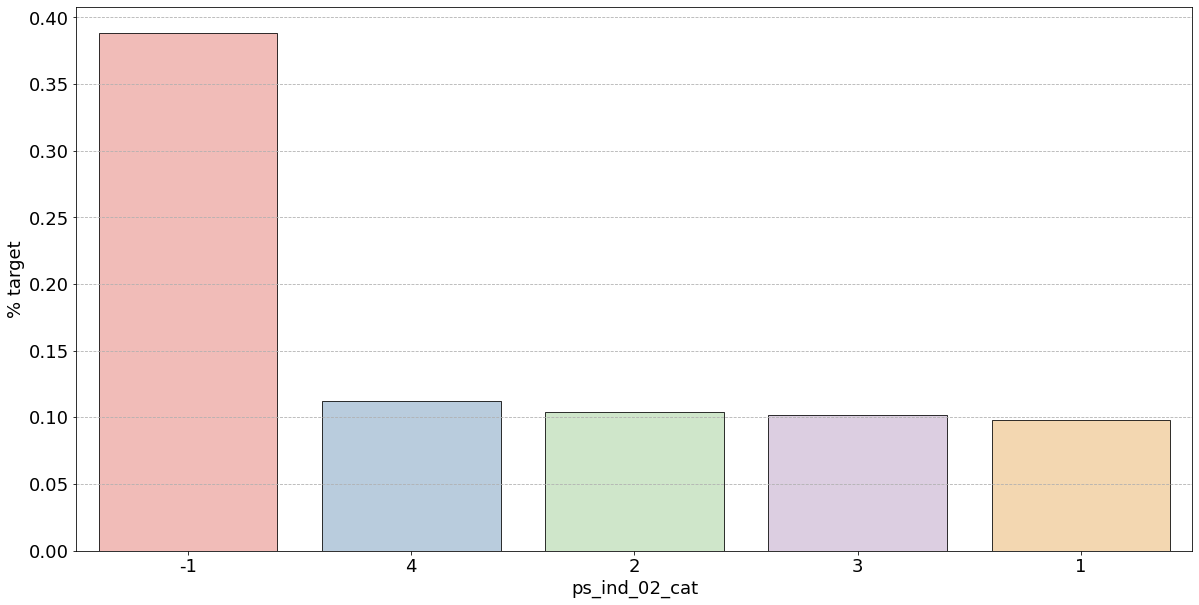

<Figure size 432x288 with 0 Axes>

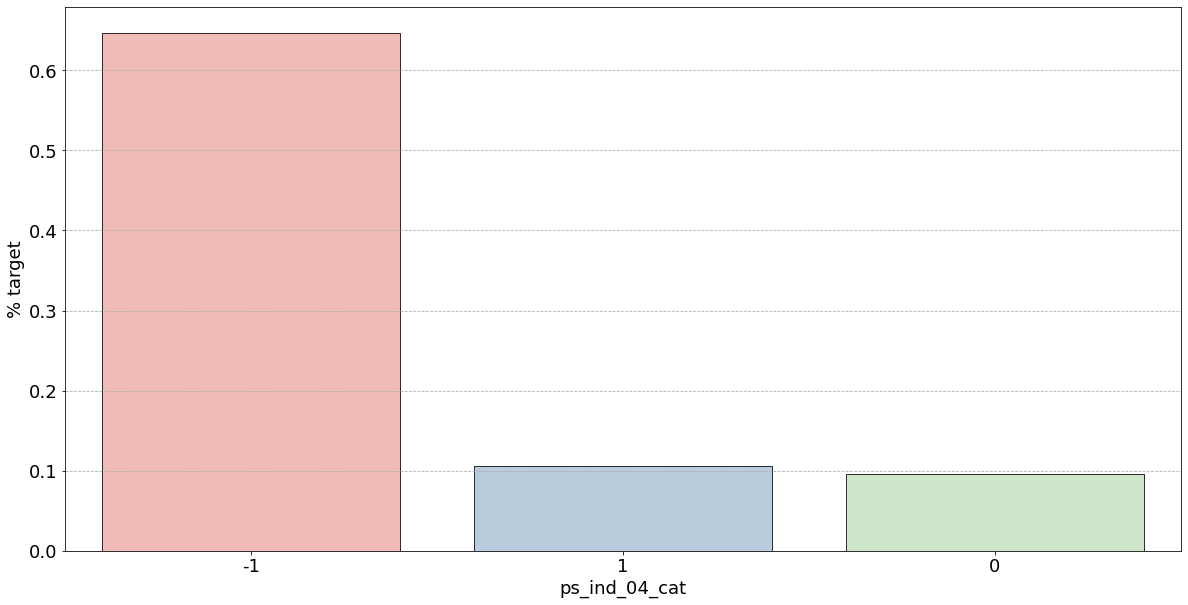

<Figure size 432x288 with 0 Axes>

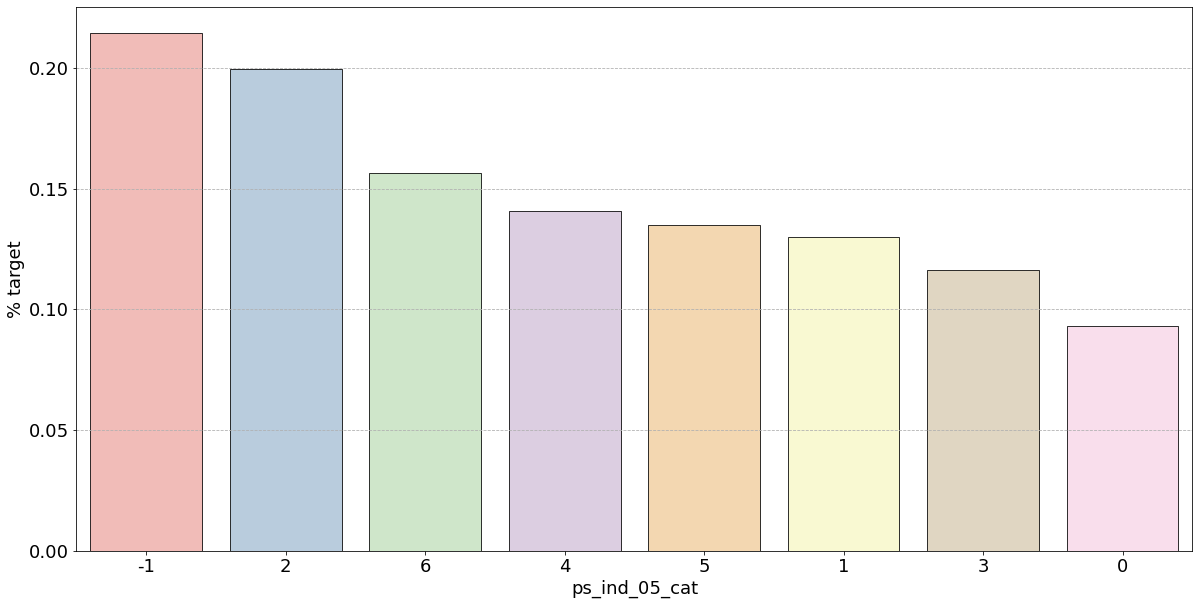

<Figure size 432x288 with 0 Axes>

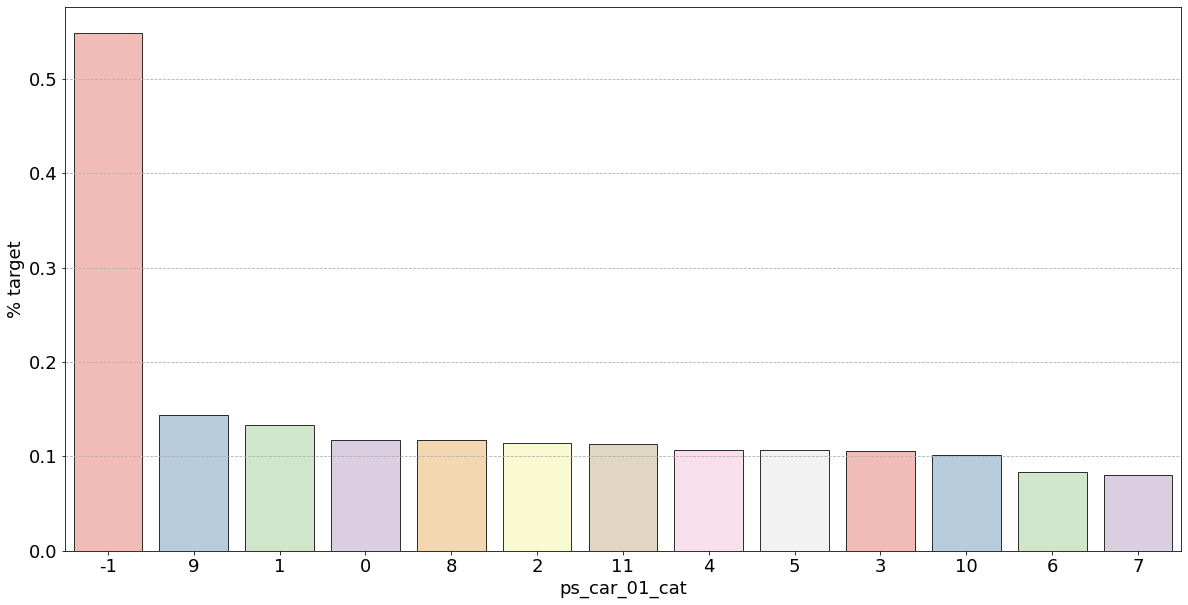

<Figure size 432x288 with 0 Axes>

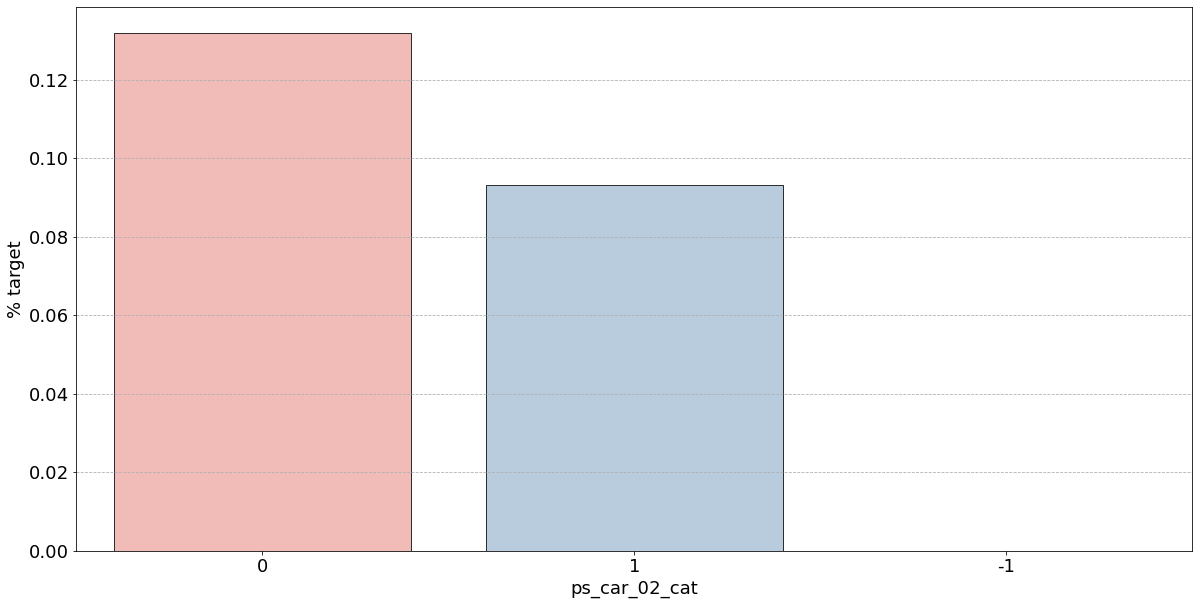

<Figure size 432x288 with 0 Axes>

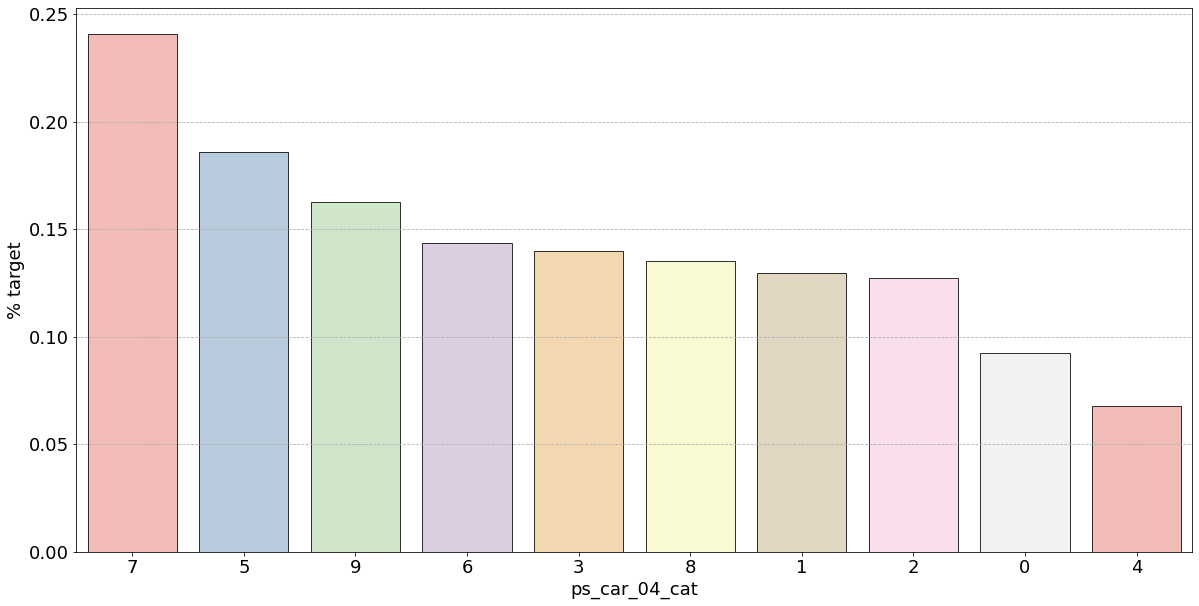

<Figure size 432x288 with 0 Axes>

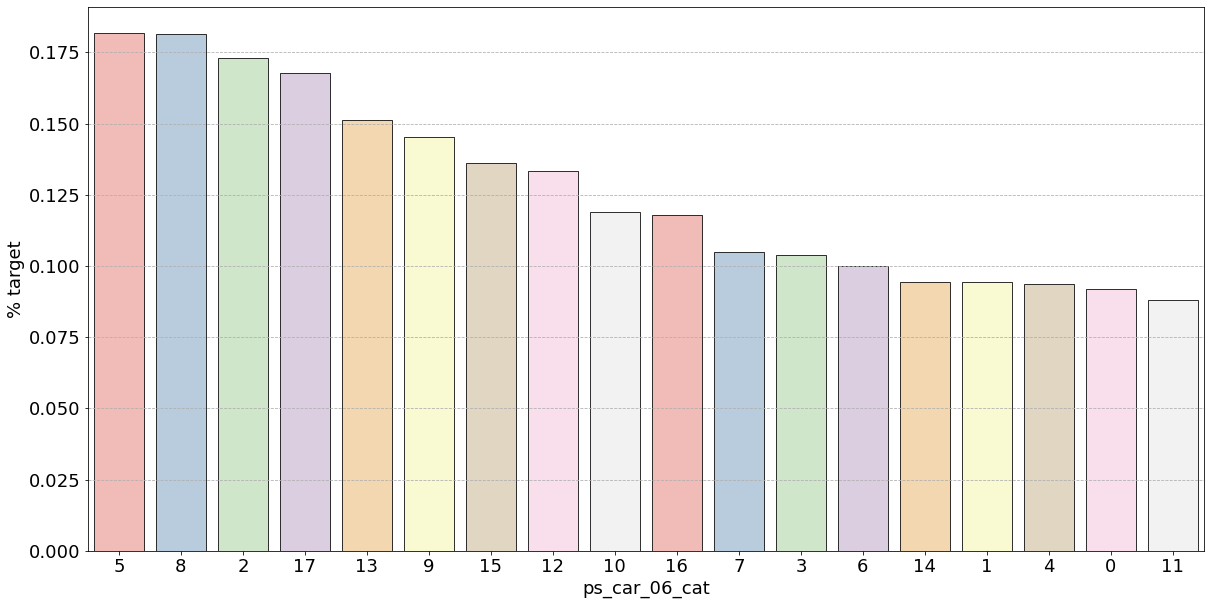

<Figure size 432x288 with 0 Axes>

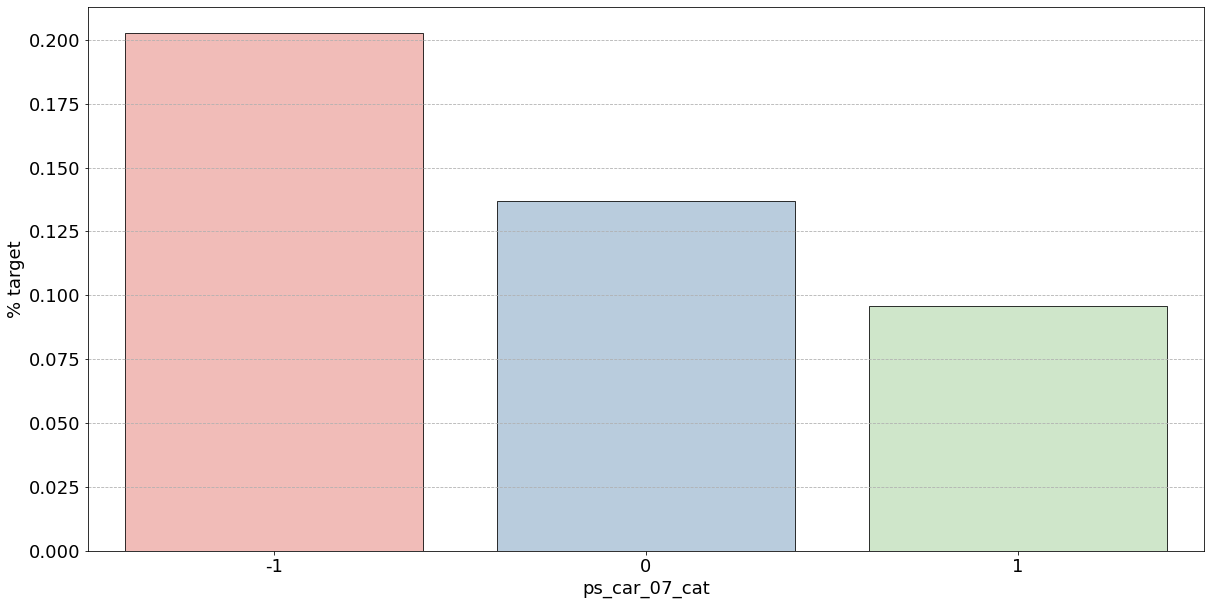

<Figure size 432x288 with 0 Axes>

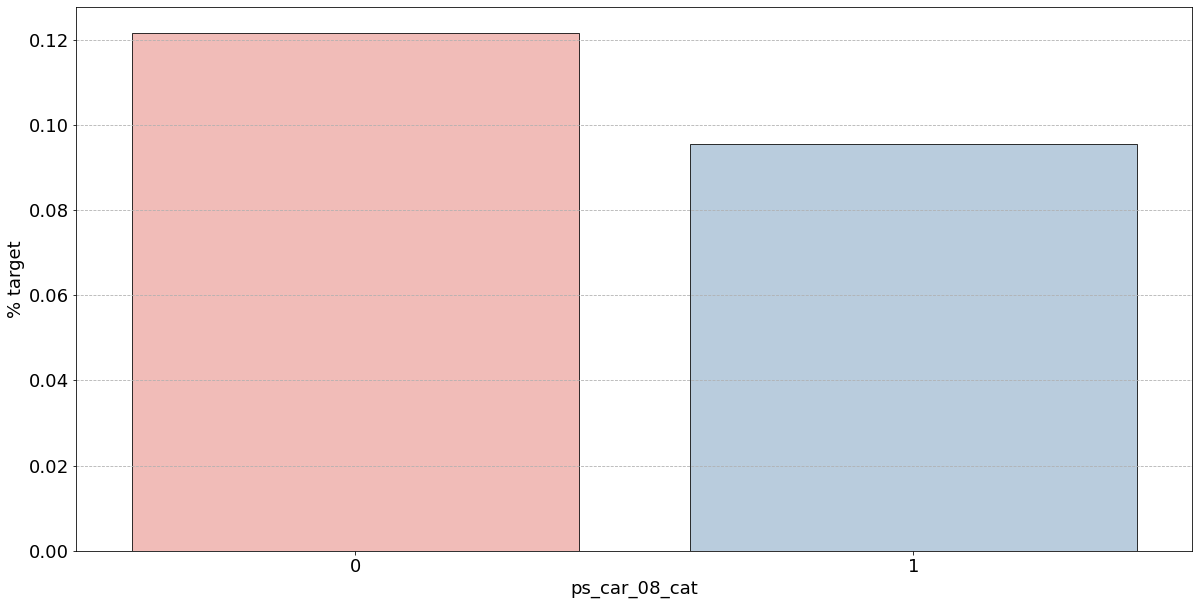

<Figure size 432x288 with 0 Axes>

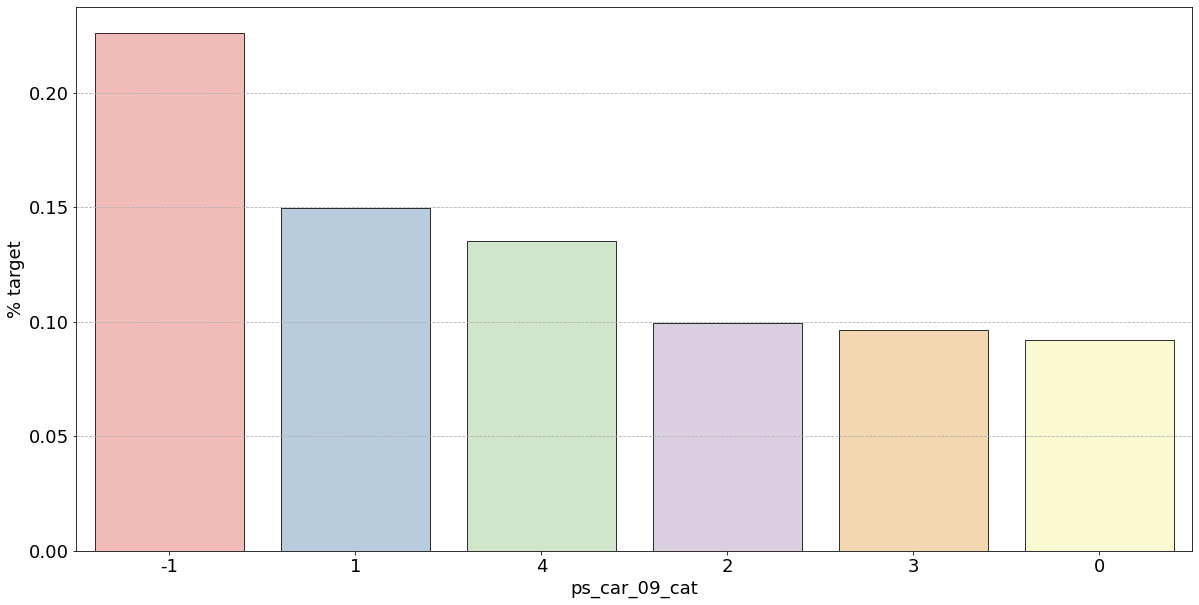

<Figure size 432x288 with 0 Axes>

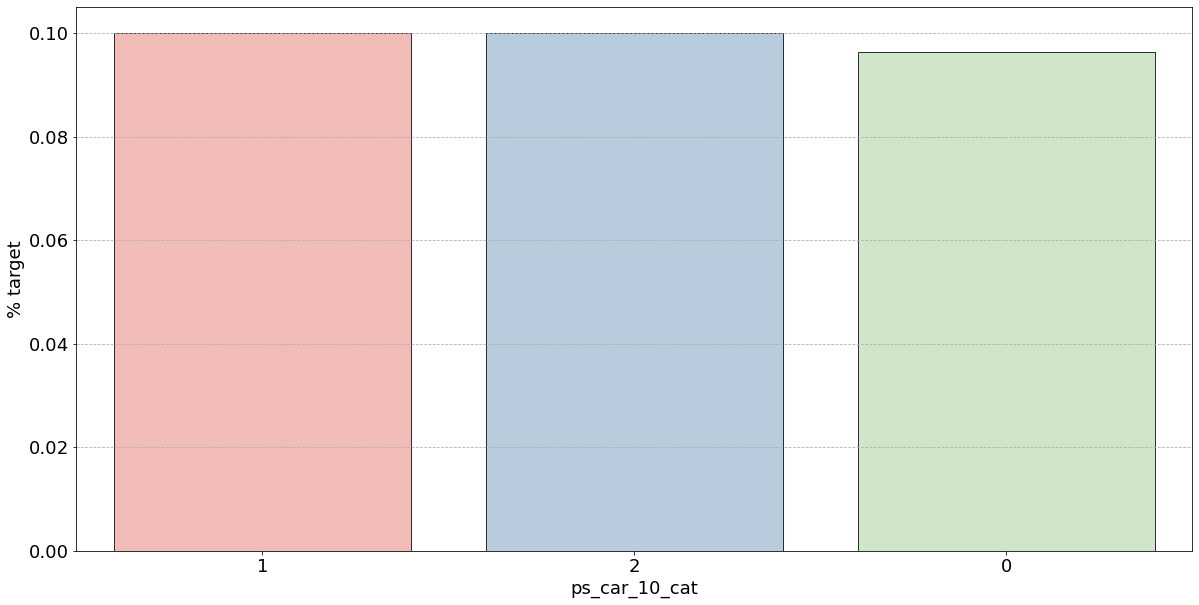

In [31]:
Nominal = meta[(meta["level"] == 'nominal') & (meta["keep"])].index


# 변수별로 반복문을 돌려서 barplot을 그린다.
for f in Nominal:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    ax.grid(axis = "y", linestyle='--')
    # 변수 별 target=1의 비율 계산
    cat_perc = df_train[[f, 'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    
    # 위에서 계산해준 비율을 통해 target = 1의 데이터 중 어떤 유니크값의 비율이 높은지 확인할 수 있다.
    sns.barplot(ax=ax, x=f, y='target',palette = "Pastel1", edgecolor='black', linewidth=0.8, data=cat_perc, order=cat_perc[f], )
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();

## 범주형 변수 시각화 결과 확인

* 주의해야할 점: 이 커널에서 시각화한 barplot만 놓고 보면 잘못된 인사이트를 얻을 수 있다. (단순 비율로만 계산하고 count 값은 고려하지 못하므로, 특히 위에서 확인했듯이 결측치가 많은 것은 대체해줬으므로 -1 값의 count는 작은것 밖에 남지 않았음) <br>
* 추가로 생각해보면 좋을 점: 보통 범주형변수의 countplot이나 barplot을 그릴때 groupby(hue를 지정)하여 살펴보면 어떤 Feature를 만들 수 있을지 생각해볼 수 있고, 더 다양한 인사이트를 얻을 수 있다.<br>
                                                                                                                                  

1) ps_ind_02_cat: -1(결측치)의 경우 target = 1의 데이터가 40%를 차지한다. 나머지는 10% 정도로 보인다.<br>
                      여기서 주의해야할 점은 높다고 좋은게 아니라는 것이다 (target에 대한 비율이기 때문에 50%에 가까울수록 애매한 unique 값이라는 뜻)<br>
                      차라리 10%를 보이는 나머지 unique 값들이 보험 청구를 안할 확률이 높다는 뜻이므로 오히려 확실한 정보라고 할 수 있다.<br>

2) ps_ind_04_cat: -1(결측치)가 65% 정도로 target = 1의 값을 가진다. 보험을 청구할 확률이 높아보인다.<br>

3) ps_ind_05_cat: unique 값 마다 차이가 있지만 눈에 띄는 unique 값은 없다.<br>

4) ps_car_01_cat: -1(결측치)가 거의 50%에 가까우므로 애매하다고 할 수 있다. 나머지 값은 다 보험을 청구하지 않을 확률이 높아보인다.<br>

5) ps_car_02_cat: -1(결측치)가 0%이다. 보험을 절대 청구하지 않을 것으로 보인다. <br>

6) 그 외: unique 값 마다 어느정도 차이들을 보인다.    <br>


일단 커널을 따라가도록 하겠다. <br>
커널에 따르면 결측값이 특이한 경우가 많으므로 대체하기 보다 그냥 두는게 나을것 같다고 판단하였다. <br>

## Interval 변수 시각화 (연속형)

- heatmap으로 상관관계 파악

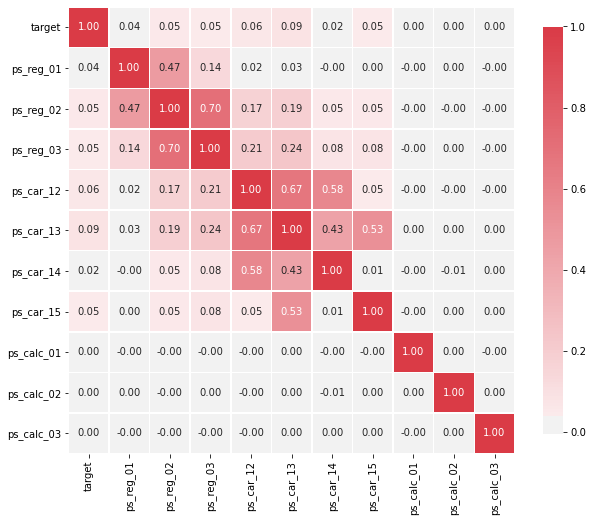

In [32]:
def corr_heatmap(Interval):
    correlations = df_train[Interval].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
Interval = meta[(meta["role"] == "target") | (meta["level"] == 'interval') & (meta["keep"])].index
corr_heatmap(Interval)

### 몇개의 변수들은 강한 상관관계를 보인다.

- ps_reg_02 & ps_reg_03 (0.7)
- ps_car_12 & ps_car13 (0.67)
- ps_car_12 & ps_car14 (0.58)
- ps_car_13 & ps_car15 (0.67)

살펴본 강한 상관관계를 가지는 변수들에 대해 추가로 시각화를 진행하도록 한다.

In [33]:
# plot을 만드는데 꽤나 긴 시간이 걸리기 때문에 10%의 sample만 뽑아서 사용

# s = df_train.sample(frac=0.1)

### 1) ps_reg_02 & ps_reg_03

- plot을 보면 두 개의 변수가 선형관계를 이루는 것을 확인할 수 있다. 
- 회귀선이 겹치거나 비슷한 모습이다.

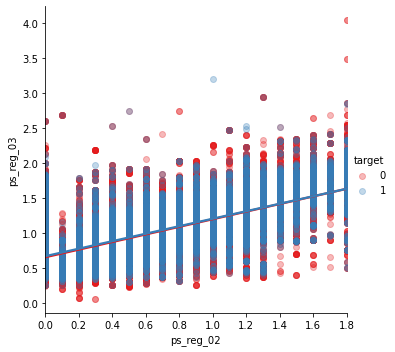

In [34]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=df_train, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

### ps_car_12 & ps_car_13

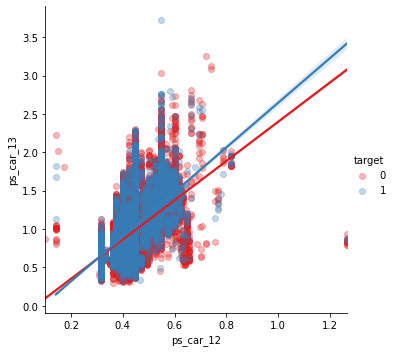

In [35]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=df_train, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

### ps_car_12 and ps_car_14

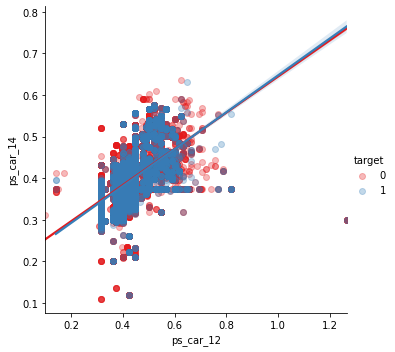

In [36]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=df_train, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

### ps_car_13 & ps_car_15

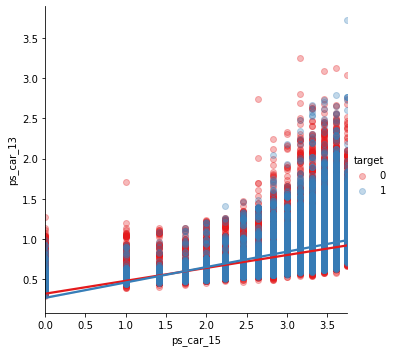

In [37]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=df_train, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

## Ordinal 변수 시각화

- heatmap으로 상관관계 파악
- 순서형 변수의 경우 변수간에 큰 상관관계를 보이지 않음

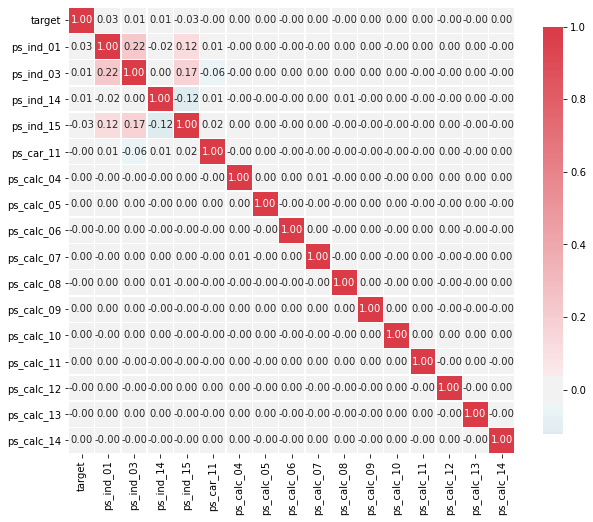

In [38]:
Ordinal = meta[(meta["role"] == "target") | (meta["level"] == 'ordinal') & (meta["keep"])].index
corr_heatmap(Ordinal)

## Feature Engineering

- 위에서 가장 많은 unique 값을 갖는 범주형 변수에 대해서 mean-encoding을 해주었다. <br>
- 나머지 변수들은 one-hot encoding 해주어 더미화 시켜준다 <br>
- 범주형 변수에 순서도 부여하지 않고, unique 값도 많지 않아 차원이 많이 늘어나지도 않는다. <br>

In [39]:
Nominal = meta[(meta["level"] == 'nominal') & (meta["keep"])].index
print('One-Hot Encoding 전 train 데이터 셋 변수 개수: {}'.format(df_train.shape[1]))
df_train = pd.get_dummies(df_train, columns=Nominal, drop_first=True)
df_test = pd.get_dummies(df_test, columns=Nominal, drop_first=True)
print('One-Hot Encoding 후 train 데이터 셋 변수 개수: {}'.format(df_train.shape[1]))

# 52개의 변수가 늘어났다.

One-Hot Encoding 전 train 데이터 셋 변수 개수: 57
One-Hot Encoding 후 train 데이터 셋 변수 개수: 109


### 교호작용 변수 생성 (중요 변수끼리의 곱)

- PolynomialFeatures 사용 
- 입력값 x를 다항식으로 변환 (x >> [1, x, x^2, x^3...])
- 열의 개수가 2개라면 (x1, x2 >> [1, x1, x2, x1^2, x2^2, x1x2])
- poly.get_feature_names를 통해 편하게 feature의 이름을 지정해줄 수 있다.

### Parameter
1. degree: 차수
2. interaction_only: 상호작용 항만 출력 (x1, x2일 때 자신의 제곱항은 무시하고 x1x2 만 출력)
3. include_bias: 상수항 생성 여부

In [40]:
Interval = meta[(meta["level"] == 'interval') & (meta["keep"])].index

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(df_train[Interval]), columns=poly.get_feature_names(Interval))
interactions.drop(Interval, axis=1, inplace=True)  # interactions 데이터프레임에서 기존 변수 삭제

# 새로 만든 변수들을 기존 데이터에 concat 시켜줌
print('교호작용 변수 생성 전 train 데이터 셋 변수 개수: {}'.format(df_train.shape[1]))
df_train = pd.concat([df_train, interactions], axis=1)
df_test = pd.concat([df_test, interactions], axis=1)
print('교호작용 변수 생성 후 train 데이터 셋 변수 개수: {}'.format(df_train.shape[1]))

교호작용 변수 생성 전 train 데이터 셋 변수 개수: 109
교호작용 변수 생성 후 train 데이터 셋 변수 개수: 164


In [41]:
# 만들어진 feature 확인

df_train.head()

,id,target,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_car_11_cat_te,ps_ind_02_cat_1,ps_ind_02_cat_2,ps_ind_02_cat_3,ps_ind_02_cat_4,...,ps_reg_01 ps_car_14,ps_reg_01 ps_car_15,ps_reg_01 ps_calc_01,ps_reg_01 ps_calc_02,ps_reg_01 ps_calc_03,ps_reg_02^2,ps_reg_02 ps_reg_03,ps_reg_02 ps_car_12,ps_reg_02 ps_car_13,ps_reg_02 ps_car_14,ps_reg_02 ps_car_15,ps_reg_02 ps_calc_01,ps_reg_02 ps_calc_02,ps_reg_02 ps_calc_03,ps_reg_03^2,ps_reg_03 ps_car_12,ps_reg_03 ps_car_13,ps_reg_03 ps_car_14,ps_reg_03 ps_car_15,ps_reg_03 ps_calc_01,ps_reg_03 ps_calc_02,ps_reg_03 ps_calc_03,ps_car_12^2,ps_car_12 ps_car_13,ps_car_12 ps_car_14,ps_car_12 ps_car_15,ps_car_12 ps_calc_01,ps_car_12 ps_calc_02,ps_car_12 ps_calc_03,ps_car_13^2,ps_car_13 ps_car_14,ps_car_13 ps_car_15,ps_car_13 ps_calc_01,ps_car_13 ps_calc_02,ps_car_13 ps_calc_03,ps_car_14^2,ps_car_14 ps_car_15,ps_car_14 ps_calc_01,ps_car_14 ps_calc_02,ps_car_14 ps_calc_03,ps_car_15^2,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01^2,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02^2,ps_calc_02 ps_calc_03,ps_calc_03^2
0,353762,0,1,1,1,0,0,0,0,0,0,0,0,11,0,1,0,0.6,0.6,0.838153,1,0.368782,0.540603,0.345688,2.000000,0.9,0.3,0.0,3,0,7,3,8,4,8,1,0,4,6,0,1,1,0,0,1,0.094006,1,0,0,0,...,0.207413,1.200000,0.54,0.18,0.00,0.36,0.502892,0.221269,0.324362,0.207413,1.200000,0.54,0.18,0.00,0.702500,0.309095,0.453108,0.289739,1.676305,0.754337,0.251446,0.000000,0.136,0.199365,0.127483,0.737564,0.331904,0.110635,0.000000,0.292252,0.186880,1.081207,0.486543,0.162181,0.000000,0.1195,0.691375,0.311119,0.103706,0.000000,4.0,1.800000,0.600000,0.000000,0.81,0.27,0.00,0.09,0.00,0.00
1,845629,0,5,7,1,0,0,0,0,0,0,0,0,5,0,0,1,0.9,0.6,0.728440,1,0.424264,0.382953,0.378814,0.000000,0.2,0.0,0.6,1,1,7,5,10,4,11,3,0,3,7,0,0,0,0,1,0,0.122660,1,0,0,0,...,0.340933,0.000000,0.18,0.00,0.54,0.36,0.437064,0.254558,0.229772,0.227288,0.000000,0.12,0.00,0.36,0.530625,0.309051,0.278958,0.275943,0.000000,0.145688,0.000000,0.437064,0.180,0.162473,0.160717,0.000000,0.084853,0.000000,0.254558,0.146653,0.145068,0.000000,0.076591,0.000000,0.229772,0.1435,0.000000,0.075763,0.000000,0.227288,0.0,0.000000,0.000000,0.000000,0.04,0.00,0.12,0.00,0.00,0.36
2,1449185,0,4,3,1,0,0,0,0,0,0,0,0,4,1,0,0,0.9,0.6,0.869267,3,0.400000,0.814271,0.402368,3.316625,0.3,0.9,0.1,4,1,8,5,10,2,8,7,2,3,10,0,1,0,1,0,1,0.096118,1,0,0,0,...,0.362131,2.984962,0.27,0.81,0.09,0.36,0.521560,0.240000,0.488563,0.241421,1.989975,0.18,0.54,0.06,0.755625,0.347707,0.707819,0.349765,2.883032,0.260780,0.782340,0.086927,0.160,0.325708,0.160947,1.326650,0.120000,0.360000,0.040000,0.663037,0.327637,2.700631,0.244281,0.732844,0.081427,0.1619,1.334504,0.120710,0.362131,0.040237,11.0,0.994987,2.984962,0.331662,0.09,0.27,0.03,0.81,0.09,0.01
3,834066,0,6,6,1,0,0,0,0,0,0,0,0,8,1,0,0,0.6,1.5,1.705872,2,0.400000,0.838387,0.378418,3.605551,0.8,0.4,0.1,3,3,7,2,11,3,10,2,2,0,14,0,0,0,0,0,0,0.086604,1,0,0,0,...,0.227051,2.163331,0.48,0.24,0.06,2.25,2.558808,0.600000,1.257580,0.567627,5.408327,1.20,0.60,0.15,2.910000,0.682349,1.430181,0.645532,6.150610,1.364698,0.682349,0.170587,0.160,0.335355,0.151367,1.442221,0.320000,0.160000,0.040000,0.702893,0.317260,3.022847,0.670710,0.335355,0.083839,0.1432,1.364405,0.302734,0.151367,0.037842,13.0,2.884441,1.442221,0.360555,0.64,0.32,0.08,0.16,0.04,0.01
4,436189,0,5,5,0,0,1,0,0,0,0,0,0,10,1,0,0,0.8,0.8,1.086566,3,0.400000,0.905777,0.384838,3.605551,0.6,0.5,0.9,3,3,5,2,9,1,6,5,1,6,8,0,1,1,1,0,1,0.108273,1,0,0,0,...,0.307870,2.884441,0.48,0.40,0.72,0.64,0.869253,0.

# 상위커널 Discussion

- 캐글의 경우 금메달 커널은 리뷰하는 것도 굉장히 도움이 많이 되지만, 정말 알짜 정보들은 Discussion에 많이 몰려있다.
- 당연히 대회가 끝나기 전에는 Solution이 올라오지는 않지만, Discussion에서 확인할 수 있는 작은 인사이트들이 큰 도움이 되는 경우가 많다.


## 1등 Discussion 정리

1) 모델: LightGBM, NeuralNet 사용 (오토인코더: 비지도 학습 기반 뉴럴 넷, 이미지 복원등에 주로 사용, 노이즈 제거에 특화되어 있음)<br>
 - Discussion과 상위 커널 몇개를 살펴본 결과 노이즈를 처리하는 것이 대회의 핵심이었던것 같음 <br>
 - 그래서 대회 우승자들은 일반적인 머신러닝 모델 + 딥러닝 모델을 사용한것으로 보임 <br>
 - 오토인코더 참고: https://sunghan-kim.github.io/ml/3min-dl-ch08/# <br>
 
2) FE: cals 변수 제거, cat 변수 one-hot encoding<br>
 - 딱히 많은 파생변수를 만들어내지 않았음에도 1등을 차지함 (데이터의 특성에 맞는 모델을 사용한 결과) <br>
 
3) Scaling: 일반 트리모델이 아닌 딥러닝 모델을 사용하였기 때문에 필수적으로 사용 (RankGauss라는 기법을 사용했다고 한다.)<br>
 - RankGauss라는 기법은 태어나서 처음보는 표준화 방법;; (구글링 결과 한글 포스팅 없음, 공부해서 블로그 올리자 얘들아 ^^)<br>
 - 이런 새로운 기법을 알아가고 공부할 수 있는 것이 캐글을 하는 이유가 아닐까..<br>
 - RankGauss 참고: https://github.com/aldente0630/gauss_rank_scaler 


## 3등 Discussion 정리

1) 모델: LightGBM, NeuralNet 사용 (역시 오토인코더 사용) <br>

2) FE:  머신러닝 모델에서 <br> 
['ps_ind_14', 'ps_car_10_cat', 'ps_car_14', 'ps_ind_10_bin', 'ps_ind_11_bin','ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_11', 'ps_car_12'] <br>
이 변수들을 삭제했다고함, 교차검증 점수 확인하며 삭제
 - one-hot encoding이 노이즈를 줄이는데 도움이 되었다고 한다.<br>

3) 아쉬웠던 점은, 이상치를 제대로 파악하지 못했다고 한다. 
 - 위의 EDA에서 살펴보았던 count는 적지만 1으로 분류될 확률이 엄청 높았던 -1(결측치)라든지 그런 부분을 이야기하는 것 같음
